In [1]:

# Import necessary libraries
import pandas as pd  # Import Pandas for data handling
import os  # Import OS for file operations
import seaborn as sns  # Import Seaborn for data visualization
import numpy as np  # Import NumPy for numerical operations
import matplotlib.pyplot as plt  # Import Matplotlib for plotting
import numpy as np

#Tensorflow modules
from tensorflow.keras.models import Sequential  # Import Sequential for building neural networks
from sklearn import preprocessing
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, BatchNormalization  # Import various layers for building the model
from sklearn.metrics import confusion_matrix  # Import metrics for model evaluation
from sklearn.model_selection import train_test_split  # Import train-test split for data splitting
from tensorflow.keras.optimizers import Adam, SGD # Import Adam optimizer for training
from sklearn.preprocessing import StandardScaler, MinMaxScaler  # Import data scalers
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping  # Import callbacks for model training
import tensorflow as tf  # Import TensorFlow for deep learning
from tensorflow.keras.preprocessing.image import ImageDataGenerator #Imort Image DataGEnerator for Data augumentation


In [3]:
#Display Images using OPenCV
from google.colab.patches import cv2_imshow

import warnings
warnings.filterwarnings('ignore')

## Reading the Dataset

In [7]:
#upload csv file and read
from google.colab import files
uploaded = files.upload()


Saving CovidLabels.csv to CovidLabels.csv


In [5]:
#upload csv file and read
from google.colab import files
uploaded = files.upload()


Saving CovidImages.npy to CovidImages (1).npy


In [8]:
# Load the NPY file
images = np.load("CovidImages.npy")

# Load the labels file
labels = pd.read_csv("CovidLabels.csv")

## Overview of the dataset

In [9]:
print(images.shape)
print(labels.shape)

(251, 128, 128, 3)
(251, 1)


there are 251 BGR images of shape 128 x 128 x 3 each. each image has 3 or colored channels

## Converting the images from BGR to RGB

In [10]:
import cv2
# Converting the images from BGR to RGB using cvtcolor function of OpenCV
for i in range(len(images)):
  images[i] = cv2.cvtColor(images[i], cv2.COLOR_BGR2RGB)


In [11]:
np.unique(labels)

array(['Covid', 'Normal', 'Viral Pneumonia'], dtype=object)

## Exploratory Data Analysis

In [12]:
import random
def plot_image(images, labels):
    rows, cols = 3, 3  # Set your desired number of rows and columns
    fig = plt.figure(figsize=(12, 12))

    for i in range(rows * cols):
        random_index = random.randint(0, len(images) - 1)
        ax = fig.add_subplot(rows, cols, i + 1)
        ax.imshow(images[random_index])

        # Check if the label exists in the 'Label' column
        label_value = labels['Label'][random_index] if 'Label' in labels and random_index < len(labels['Label']) else 'Unknown'

        ax.set_title(label_value)

    plt.tight_layout()
    plt.show()


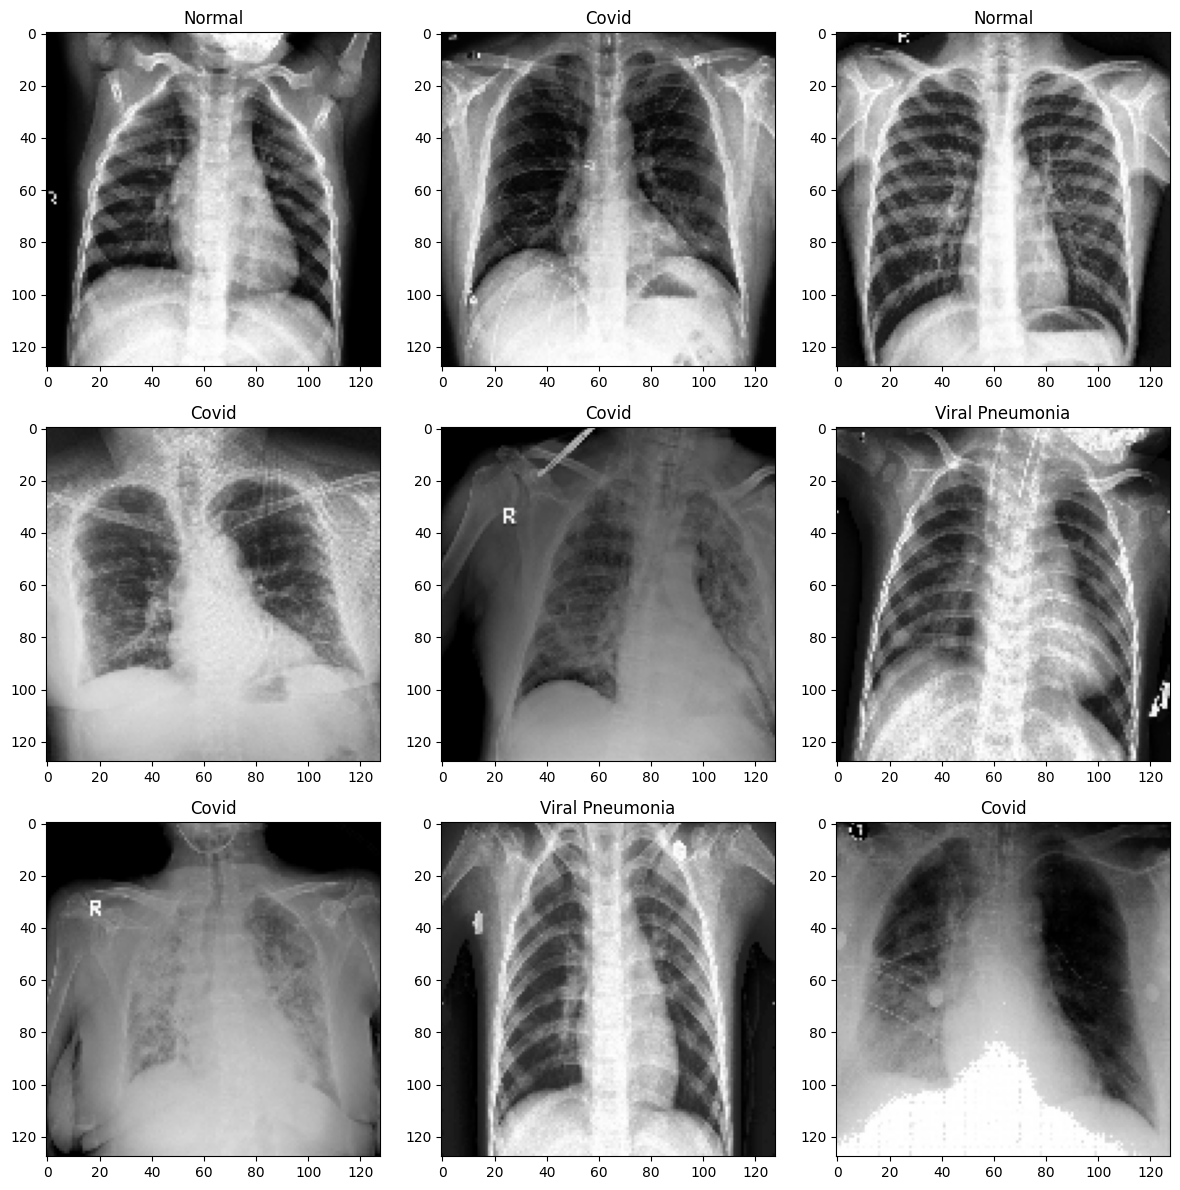

In [13]:
# Call the function with your images and labels
plot_image(images, labels)

## Checking for data imbalance

(array([0, 1, 2]),
 [Text(0, 0, 'Viral Pneumonia'), Text(1, 0, 'Covid'), Text(2, 0, 'Normal')])

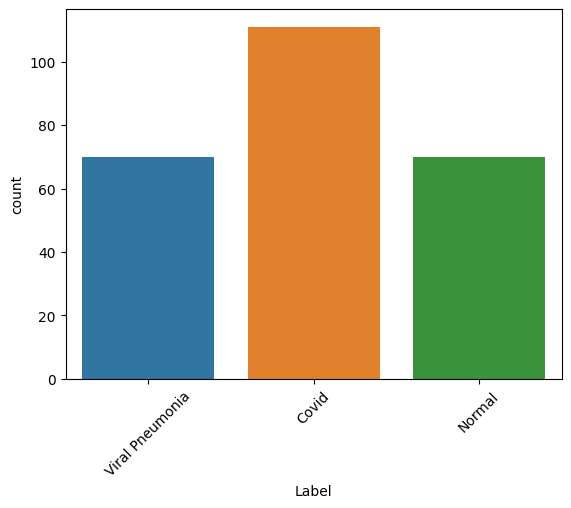

In [14]:
sns.countplot(data = labels, x = 'Label')
plt.xticks(rotation = 45)

the labels are imbalanced and so a transfer learning model will suffice

## Encoding the target labels

In [18]:
import numpy as np
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define the number of classes
num_classes = 3

# Extract the feature data (X) and target labels (y)
X = images  # Assuming your images are stored in the 'images' variable
y = labels['Label']  # Assuming the label column is named 'Label' in your CSV file

# Apply label encoding to the target labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Define the number of folds
n_splits = 5  # Adjust as needed

# Initialize cross-validator (StratifiedKFold is used for stratified sampling)
kf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

# Define parameters for the pre-trained model
base_model = MobileNetV2(weights='imagenet', include_top=False)
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(num_classes, activation='softmax')(x)  # Replace num_classes with your number of classes
model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Iterate through the folds
for fold, (train_index, val_index) in enumerate(kf.split(X, y_encoded)):
    X_train, X_val = X[train_index], X[val_index]
    y_train, y_val = y_encoded[train_index], y_encoded[val_index]

    # Data augmentation for training data
    train_datagen = ImageDataGenerator(
        # Apply data augmentation options as needed (e.g., rotation, width_shift, height_shift, etc.)
    )

    # Data augmentation for validation data (usually minimal or none)
    val_datagen = ImageDataGenerator()

    # Train the model on the current fold
    model.fit(train_datagen.flow(X_train, y_train, batch_size=32), epochs=5, validation_data=val_datagen.flow(X_val, y_val, batch_size=32))

    # Evaluate the model on the validation set for this fold
    val_loss, val_acc = model.evaluate(X_val, y_val)
    print(f'Fold {fold + 1} - Validation accuracy: {val_acc}')

from tensorflow.keras.models import load_model

# Save the model to a file
model.save('my_transfer_learning_model.h5')


# Optionally, average or aggregate performance metrics across the folds


Epoch 1/5
7/7 [==============================] - 45s 535ms/step - loss: 0.7923 - accuracy: 0.6200 - val_loss: 1.1585 - val_accuracy: 0.4314
Epoch 2/5
7/7 [==============================] - 1s 92ms/step - loss: 0.1605 - accuracy: 0.9700 - val_loss: 1.0564 - val_accuracy: 0.4706
Epoch 3/5
7/7 [==============================] - 1s 86ms/step - loss: 0.0680 - accuracy: 0.9900 - val_loss: 0.9315 - val_accuracy: 0.6471
Epoch 4/5
7/7 [==============================] - 1s 88ms/step - loss: 0.0278 - accuracy: 1.0000 - val_loss: 0.8806 - val_accuracy: 0.6667
Epoch 5/5
2/2 [==============================] - 1s 27ms/step - loss: 0.8383 - accuracy: 0.6667
Fold 1 - Validation accuracy: 0.6666666865348816
Epoch 1/5
7/7 [==============================] - 1s 88ms/step - loss: 0.1669 - accuracy: 0.9453 - val_loss: 1.5016 - val_accuracy: 0.3800
Epoch 2/5
7/7 [==============================] - 1s 74ms/step - loss: 0.0313 - accuracy: 0.9950 - val_loss: 1.6212 - val_accuracy: 0.4000
Epoch 3/5
7/7 [==========

# New section

Epoch 1/5
7/7 [==============================] - 1s 106ms/step - loss: 0.0020 - accuracy: 1.0000 - val_loss: 1.5505 - val_accuracy: 0.7843
Epoch 2/5
7/7 [==============================] - 1s 138ms/step - loss: 0.0193 - accuracy: 0.9900 - val_loss: 1.9625 - val_accuracy: 0.7255
Epoch 3/5
7/7 [==============================] - 0s 61ms/step - loss: 5.5240e-04 - accuracy: 1.0000 - val_loss: 2.1767 - val_accuracy: 0.6667
Epoch 4/5
7/7 [==============================] - 0s 62ms/step - loss: 0.0014 - accuracy: 1.0000 - val_loss: 2.2412 - val_accuracy: 0.6667
Epoch 5/5
2/2 [==============================] - 0s 17ms/step - loss: 2.2125 - accuracy: 0.6667
Fold 1 - Validation accuracy: 0.6666666865348816
Epoch 1/5
7/7 [==============================] - 0s 67ms/step - loss: 0.0018 - accuracy: 1.0000 - val_loss: 2.8509 - val_accuracy: 0.6200
Epoch 2/5
7/7 [==============================] - 0s 62ms/step - loss: 0.0016 - accuracy: 1.0000 - val_loss: 2.8063 - val_accuracy: 0.6200
Epoch 3/5
7/7 [======

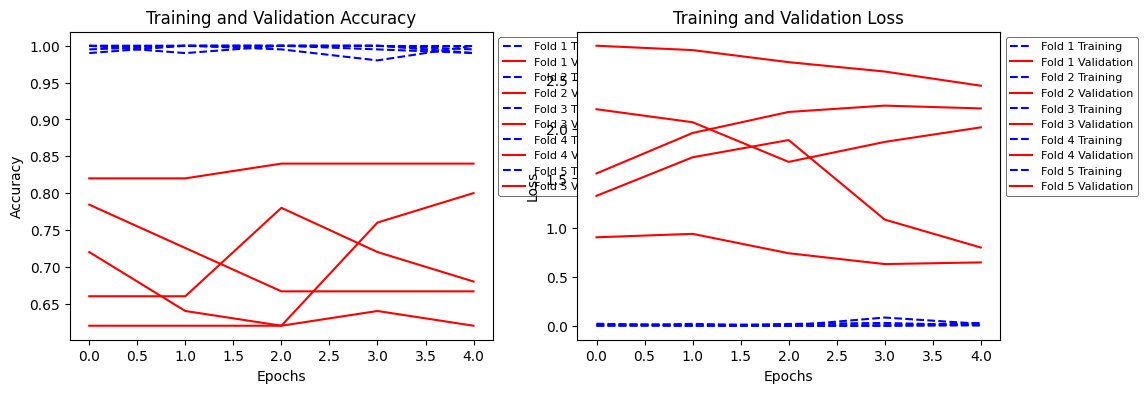

In [23]:
import matplotlib.pyplot as plt
import numpy as np

# Lists to store training and validation accuracy and loss for each fold
train_acc_history = []
val_acc_history = []
train_loss_history = []
val_loss_history = []

# Iterate through the folds
for fold, (train_index, val_index) in enumerate(kf.split(X, y_encoded)):
    X_train, X_val = X[train_index], X[val_index]
    y_train, y_val = y_encoded[train_index], y_encoded[val_index]

    # Data augmentation for training data
    train_datagen = ImageDataGenerator(
        # Apply data augmentation options as needed
    )

    # Data augmentation for validation data (usually minimal or none)
    val_datagen = ImageDataGenerator()

    # Train the model on the current fold
    history = model.fit(
        train_datagen.flow(X_train, y_train, batch_size=32),
        epochs=5,
        validation_data=val_datagen.flow(X_val, y_val, batch_size=32)
    )

    # Append training and validation accuracy and loss to the history lists
    train_acc_history.append(history.history['accuracy'])
    val_acc_history.append(history.history['val_accuracy'])
    train_loss_history.append(history.history['loss'])
    val_loss_history.append(history.history['val_loss'])

    # Evaluate the model on the validation set for this fold
    val_loss, val_acc = model.evaluate(X_val, y_val)
    print(f'Fold {fold + 1} - Validation accuracy: {val_acc}')

# Plot training and validation accuracy
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
for i in range(n_splits):
    plt.plot(train_acc_history[i], label=f'Fold {i + 1} Training', color='blue', linestyle='--')
    plt.plot(val_acc_history[i], label=f'Fold {i + 1} Validation', color='red')

plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

# Define the size and position of the legend
legend_acc = plt.legend(loc='upper left', bbox_to_anchor=(1, 1), prop={'size': 8})  # Adjust size and location
legend_acc.get_frame().set_linewidth(0.5)  # Set the legend border width
legend_acc.get_frame().set_edgecolor('black')  # Set the legend border color

# Plot training and validation loss
plt.subplot(1, 2, 2)
for i in range(n_splits):
    plt.plot(train_loss_history[i], label=f'Fold {i + 1} Training', color='blue', linestyle='--')
    plt.plot(val_loss_history[i], label=f'Fold {i + 1} Validation', color='red')

plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')

# Define the size and position of the legend for loss
legend_loss = plt.legend(loc='upper left', bbox_to_anchor=(1, 1), prop={'size': 8})  # Adjust size and location
legend_loss.get_frame().set_linewidth(0.5)  # Set the legend border width
legend_loss.get_frame().set_edgecolor('black')  # Set the legend border color

plt.show()


In [20]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, BatchNormalization, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# Load your dataset (X_train and y_train)
X_train = images

# Assuming the labels are stored in a pandas DataFrame and the label column is named 'Label'
y_train = labels['Label']


# Perform label encoding if needed
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)

# Check the shapes of X_train and y_train_encoded
print("X_train shape:", X_train.shape)
print("y_train_encoded shape:", y_train_encoded.shape)

# Split the data into training and validation sets
X_train, X_val, y_train_encoded, y_val = train_test_split(X_train, y_train_encoded, test_size=0.2, random_state=42)

# Check the shapes of X_train, y_train_encoded, X_val, and y_val after the split
print("X_train shape after split:", X_train.shape)
print("y_train_encoded shape after split:", y_train_encoded.shape)
print("X_val shape:", X_val.shape)
print("y_val shape:", y_val.shape)

# Define the data augmentation
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    brightness_range=(0.8, 1.2)
)

# Initialize a sequential model
model1 = Sequential()

# Add convolutional layers
model1.add(Conv2D(128, (3, 3), input_shape=(128, 128, 3), activation='relu', padding='same'))
model1.add(BatchNormalization())
model1.add(MaxPooling2D((2, 2)))

model1.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model1.add(BatchNormalization())
model1.add(MaxPooling2D((2, 2)))

model1.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model1.add(BatchNormalization())
model1.add(MaxPooling2D((2, 2)))

# Flatten to convert to 1 dimension for the dense layers
model1.add(Flatten())

# Add a fully connected dense layer with 100 neurons and dropout regularization
model1.add(Dense(100, activation='relu'))
model1.add(Dropout(0.2))

# Add the final dense layer with the number of output classes (3)
model1.add(Dense(3, activation='softmax'))

# Using the Adam optimizer
opt = Adam()

# Compile the model
model1.compile(optimizer=opt, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model with data augmentation
history1 = model1.fit(datagen.flow(X_train, y_train_encoded, batch_size=32), epochs=10, validation_data=(X_val, y_val))

# Save the trained model to a file
model1.save("radio_images.h5")


X_train shape: (251, 128, 128, 3)
y_train_encoded shape: (251,)
X_train shape after split: (200, 128, 128, 3)
y_train_encoded shape after split: (200,)
X_val shape: (51, 128, 128, 3)
y_val shape: (51,)
Epoch 1/10
7/7 [==============================] - 5s 211ms/step - loss: 2.8486 - accuracy: 0.5200 - val_loss: 66.8212 - val_accuracy: 0.3333
Epoch 2/10
7/7 [==============================] - 1s 146ms/step - loss: 1.3860 - accuracy: 0.6150 - val_loss: 113.6938 - val_accuracy: 0.2745
Epoch 3/10
7/7 [==============================] - 1s 143ms/step - loss: 1.1040 - accuracy: 0.6850 - val_loss: 77.3754 - val_accuracy: 0.2745
Epoch 4/10
7/7 [==============================] - 1s 137ms/step - loss: 0.6909 - accuracy: 0.7350 - val_loss: 51.2027 - val_accuracy: 0.2745
Epoch 5/10
7/7 [==============================] - 1s 193ms/step - loss: 0.5502 - accuracy: 0.7600 - val_loss: 31.0518 - val_accuracy: 0.2745
Epoch 6/10
7/7 [==============================] - 1s 146ms/step - loss: 0.6571 - accuracy: 0

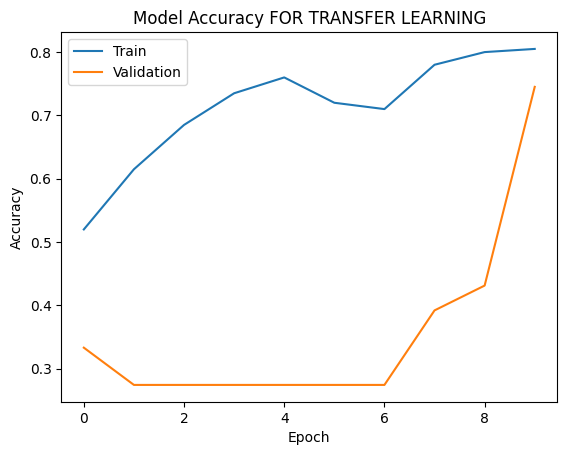

In [24]:
plt.plot(history1.history['accuracy'])
plt.plot(history1.history['val_accuracy'])
plt.title('Model Accuracy FOR TRANSFER LEARNING')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc = 'upper left')
plt.show()

In [25]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, BatchNormalization, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# Load your dataset (X_train and y_train)
# Assuming the NPY file contains image data in the 'images' variable
X_train = images

# Assuming the labels are stored in a pandas DataFrame and the label column is named 'Label'
y_train = labels['Label']


# Perform label encoding if needed
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)

# Check the shapes of X_train and y_train_encoded
print("X_train shape:", X_train.shape)
print("y_train_encoded shape:", y_train_encoded.shape)

# Split the data into training and validation sets
X_train, X_val, y_train_encoded, y_val = train_test_split(X_train, y_train_encoded, test_size=0.2, random_state=42)

# Check the shapes of X_train, y_train_encoded, X_val, and y_val after the split
print("X_train shape after split:", X_train.shape)
print("y_train_encoded shape after split:", y_train_encoded.shape)
print("X_val shape:", X_val.shape)
print("y_val shape:", y_val.shape)

# Define the data augmentation
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    brightness_range=(0.8, 1.2)
)

# Initialize a sequential model
model2 = Sequential()

# Add convolutional layers
model2.add(Conv2D(128, (3, 3), input_shape=(128, 128, 3), activation='relu', padding='same'))
#model.add(BatchNormalization())
model2.add(MaxPooling2D((2, 2)))

model2.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
###model.add(BatchNormalization())
model2.add(MaxPooling2D((2, 2)))

model2.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
#model.add(BatchNormalization())
model2.add(MaxPooling2D((2, 2)))

# Flatten to convert to 1 dimension for the dense layers
model2.add(Flatten())

# Add a fully connected dense layer with 100 neurons and dropout regularization
model2.add(Dense(100, activation='relu'))
model2.add(Dropout(0.2))

# Add the final dense layer with the number of output classes (3)
model2.add(Dense(3, activation='softmax'))

# Using the Adam optimizer
opt = Adam()

# Compile the model
model2.compile(optimizer=opt, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model with data augmentation
history2 = model2.fit(datagen.flow(X_train, y_train_encoded, batch_size=32), epochs=10, validation_data=(X_val, y_val))

# Save the trained model to a file
model2.save("radio_images2.h5")


X_train shape: (251, 128, 128, 3)
y_train_encoded shape: (251,)
X_train shape after split: (200, 128, 128, 3)
y_train_encoded shape after split: (200,)
X_val shape: (51, 128, 128, 3)
y_val shape: (51,)
Epoch 1/10
7/7 [==============================] - 3s 143ms/step - loss: 39.8309 - accuracy: 0.2650 - val_loss: 3.8170 - val_accuracy: 0.3922
Epoch 2/10
7/7 [==============================] - 1s 152ms/step - loss: 1.9375 - accuracy: 0.3950 - val_loss: 1.0578 - val_accuracy: 0.5098
Epoch 3/10
7/7 [==============================] - 2s 265ms/step - loss: 0.9595 - accuracy: 0.5550 - val_loss: 0.8510 - val_accuracy: 0.5098
Epoch 4/10
7/7 [==============================] - 1s 140ms/step - loss: 0.9020 - accuracy: 0.5000 - val_loss: 0.7300 - val_accuracy: 0.6667
Epoch 5/10
7/7 [==============================] - 1s 151ms/step - loss: 0.7743 - accuracy: 0.6500 - val_loss: 0.6174 - val_accuracy: 0.6275
Epoch 6/10
7/7 [==============================] - 1s 147ms/step - loss: 0.7689 - accuracy: 0.6350

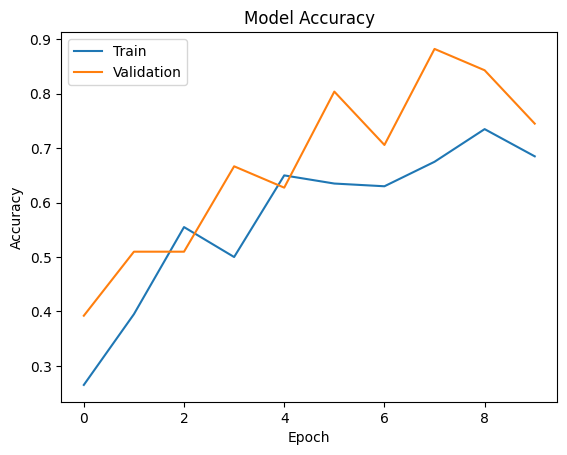

In [26]:
#plot the accuracy
plt.plot(history2.history['accuracy'])
plt.plot(history2.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc = 'upper left')
plt.show()

In [28]:
#Model building
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, BatchNormalization, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# Load your dataset (X_train and y_train)
# Assuming the NPY file contains image data in the 'images' variable
X_train = images

# Assuming the labels are stored in a pandas DataFrame and the label column is named 'Label'
y_train = labels['Label']


# Perform label encoding if needed
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)

# Check the shapes of X_train and y_train_encoded
print("X_train shape:", X_train.shape)
print("y_train_encoded shape:", y_train_encoded.shape)

# Split the data into training and validation sets
X_train, X_val, y_train_encoded, y_val = train_test_split(X_train, y_train_encoded, test_size=0.2, random_state=42)

# Check the shapes of X_train, y_train_encoded, X_val, and y_val after the split
print("X_train shape after split:", X_train.shape)
print("y_train_encoded shape after split:", y_train_encoded.shape)
print("X_val shape:", X_val.shape)
print("y_val shape:", y_val.shape)

# Define the data augmentation
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    brightness_range=(0.8, 1.2)
)

# Initialize a sequential model
model2 = Sequential()

# Add convolutional layers
model2.add(Conv2D(128, (3, 3), input_shape=(128, 128, 3), activation='relu', padding='same'))
#model.add(BatchNormalization())
model2.add(MaxPooling2D((2, 2)))

model2.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
###model.add(BatchNormalization())
model2.add(MaxPooling2D((2, 2)))

model2.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
#model.add(BatchNormalization())
model2.add(MaxPooling2D((2, 2)))

# Flatten to convert to 1 dimension for the dense layers
model2.add(Flatten())

# Add a fully connected dense layer with 100 neurons and dropout regularization
model2.add(Dense(100, activation='relu'))
model2.add(Dropout(0.2))

# Add the final dense layer with the number of output classes (3)
model2.add(Dense(3, activation='softmax'))

# Using the Adam optimizer
opt = Adam()

# Compile the model
model2.compile(optimizer=opt, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model with data augmentation
history3 = model2.fit(datagen.flow(X_train, y_train_encoded, batch_size=32), epochs=10, validation_data=(X_val, y_val))

# Save the trained model to a file
model2.save("radio_images4.h5")


X_train shape: (251, 128, 128, 3)
y_train_encoded shape: (251,)
X_train shape after split: (200, 128, 128, 3)
y_train_encoded shape after split: (200,)
X_val shape: (51, 128, 128, 3)
y_val shape: (51,)
Epoch 1/10
7/7 [==============================] - 4s 125ms/step - loss: 48.0297 - accuracy: 0.3250 - val_loss: 0.8358 - val_accuracy: 0.7059
Epoch 2/10
7/7 [==============================] - 1s 139ms/step - loss: 1.2966 - accuracy: 0.4700 - val_loss: 0.7307 - val_accuracy: 0.6275
Epoch 3/10
7/7 [==============================] - 1s 210ms/step - loss: 0.8667 - accuracy: 0.5850 - val_loss: 0.6867 - val_accuracy: 0.6863
Epoch 4/10
7/7 [==============================] - 2s 241ms/step - loss: 0.8157 - accuracy: 0.6200 - val_loss: 0.5982 - val_accuracy: 0.8039
Epoch 5/10
7/7 [==============================] - 3s 491ms/step - loss: 0.7232 - accuracy: 0.6700 - val_loss: 0.5694 - val_accuracy: 0.7059
Epoch 6/10
7/7 [==============================] - 3s 436ms/step - loss: 0.7140 - accuracy: 0.6550

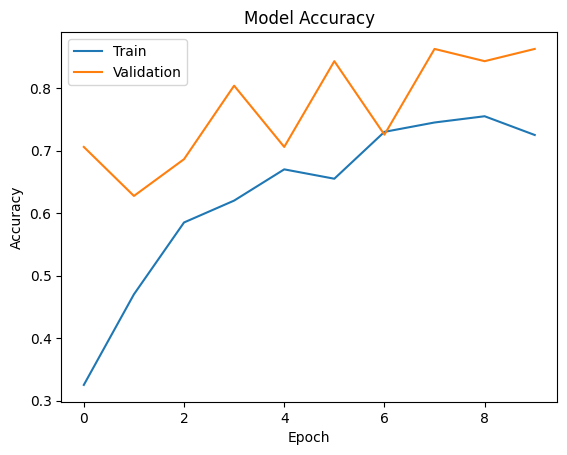

In [29]:
plt.plot(history3.history['accuracy'])
plt.plot(history3.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc = 'upper left')
plt.show()

2/2 [==============================] - 0s 9ms/step


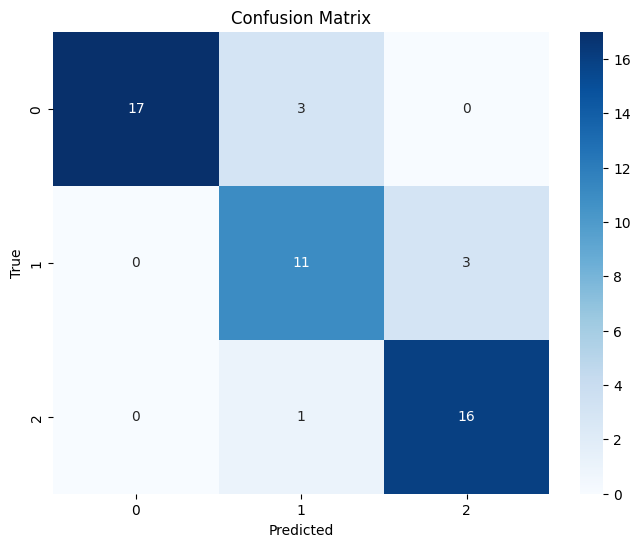

Accuracy: 0.8627450980392157
Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.85      0.92        20
           1       0.73      0.79      0.76        14
           2       0.84      0.94      0.89        17

    accuracy                           0.86        51
   macro avg       0.86      0.86      0.86        51
weighted avg       0.87      0.86      0.86        51



In [30]:
import numpy as np
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming you have a separate test dataset (X_test) and true labels (y_test)
# Make predictions on the test data
y_pred = model2.predict(X_val)

# Convert the predicted probabilities to class labels
y_pred_class = np.argmax(y_pred, axis=1)

# Compute the confusion matrix
cm = confusion_matrix(y_val, y_pred_class)

# Define class labels (replace with your actual class labels)
class_labels = ["0", "1", "2"]

# Plot the confusion matrix using a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Calculate accuracy
accuracy = accuracy_score(y_val, y_pred_class)
print("Accuracy:", accuracy)

# Generate a classification report
classification_rep = classification_report(y_val, y_pred_class, target_names=class_labels)
print("Classification Report:\n", classification_rep)
